# Assignment 2: Fall Detection

Authors:  
Lorenzo Lucchini


#### After reading the description of the data downloaded, and analyzing it's structure it seems that the first step i need to do is merge the labels to the sensor data. Not only that the data is divided in action recognition, and then into falling recognition. Further ahead, I believe I can isolate certain fall types based on the activity type. But before doing that I will create a new file with all the subjects sensor data in each actiivty, labeling if the activity is falling or not. To do this I will take all the files in the sensor_data folder downloaded, create a new file with column subjectNumber, taskID, and repetitionNumber, and then insert the data from the sensors.

In [41]:
import os
import time
import re
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, f1_score



In [133]:
def process_label_file(input_file: str, output_path: str):
    # Load the Excel file
    df = pd.read_excel(input_file, sheet_name=0)
    
    # Extract relevant columns
    df_processed = df[['Task Code (Task ID)', 'Trial ID', 'Fall_onset_frame', 'Fall_impact_frame']].copy()
    
    # Rename columns for consistency
    df_processed.columns = ['Task ID', 'Repetition ID', 'Starting Frame', 'Ending Frame']
    
    # Fill missing Task ID values with the previous valid entry
    df_processed['Task ID'].fillna(method='ffill', inplace=True)
    
    # Extract Task ID from "Task Code (Task ID)" column
    df_processed['Task ID'] = df_processed['Task ID'].astype(str).str.extract(r'\((\d+)\)')
    
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    numbers = re.findall(r'\d+', input_file)

    # Convert to integer (if needed)
    if numbers:
        extracted_number = int(numbers[0])  # Takes the first number found
        print("Extracted Number:", extracted_number)
    else:
        print("No number found in input_file")

    if extracted_number<10:
    # Define output file path
        output_file_path = os.path.join(output_path, "processed_labels_0"+str(extracted_number)+".csv")
    else:
        output_file_path = os.path.join(output_path, "processed_labels_"+str(extracted_number)+".csv")

    # Save the processed file
    df_processed.to_csv(output_file_path, index=False)
    
    return output_file_path

i = 6
while (i<9):
    process_label_file("label_data/SA0"+str(i)+"_label.xlsx","ProcessedData/label_data")
    i = i+1

i = 10
while (i<34):
    process_label_file("label_data/SA"+str(i)+"_label.xlsx","ProcessedData/label_data")
    i = i+1

i=35
while (i<39):
    process_label_file("label_data/SA"+str(i)+"_label.xlsx","ProcessedData/label_data")
    i = i+1

Extracted Number: 6
Extracted Number: 7
Extracted Number: 8
Extracted Number: 10
Extracted Number: 11
Extracted Number: 12
Extracted Number: 13
Extracted Number: 14
Extracted Number: 15
Extracted Number: 16
Extracted Number: 17
Extracted Number: 18
Extracted Number: 19
Extracted Number: 20
Extracted Number: 21
Extracted Number: 22
Extracted Number: 23
Extracted Number: 24
Extracted Number: 25
Extracted Number: 26
Extracted Number: 27
Extracted Number: 28
Extracted Number: 29
Extracted Number: 30
Extracted Number: 31
Extracted Number: 32
Extracted Number: 33
Extracted Number: 35
Extracted Number: 36
Extracted Number: 37
Extracted Number: 38


/var/folders/cm/2jwk9dv54f7g5lszxky5_vmw0000gn/T/ipykernel_49886/3347879120.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['Task ID'].fillna(method='ffill', inplace=True)
/var/folders/cm/2jwk9dv54f7g5lszxky5_vmw0000gn/T/ipykernel_49886/3347879120.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_processed['Task ID'].fillna(method='ffill', inplace=True)
/var/folders/cm/2jwk9dv54f7g5lszxky5_vmw0000gn/T/ipykernel_4988

In [134]:
def process_label_file(input_file: str, output_path: str):
    # Load the Excel file
    df = pd.read_excel(input_file, sheet_name=0)
    
    # Extract relevant columns
    df_processed = df[['Task Code (Task ID)', 'Trial ID', 'Fall_onset_frame', 'Fall_impact_frame']].copy()
    
    # Rename columns for consistency
    df_processed.columns = ['Task ID', 'Repetition ID', 'Starting Frame', 'Ending Frame']
    
    # Fill missing Task ID values with the previous valid entry
    df_processed['Task ID'].fillna(method='ffill', inplace=True)
    
    # Extract Task ID from "Task Code (Task ID)" column
    df_processed['Task ID'] = df_processed['Task ID'].astype(str).str.extract(r'\((\d+)\)')
    
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    # Define output file path
    output_file_path = os.path.join(output_path, "processed_labels.csv")
    
    # Save the processed file
    df_processed.to_csv(output_file_path, index=False)
    
    return output_file_path

def merge_sensor_data(sensor_data_folder: str, label_data_folder: str, output_folder: str):
    # Ensure output directory exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Get all subject folders in sensor data folder
    subject_folders = [f for f in os.listdir(sensor_data_folder) if os.path.isdir(os.path.join(sensor_data_folder, f))]
    
    for subject in subject_folders:
        subject_number = subject[2:]
        subject_path = os.path.join(sensor_data_folder, subject)
        
        # Get all sensor files for the subject
        sensor_files = glob.glob(os.path.join(subject_path, "*.csv"))
        
        # Load corresponding label data
        label_file_path = os.path.join(label_data_folder, f"processed_labels_{subject_number}.csv")
        label_data = None
        if os.path.exists(label_file_path):
            label_data = pd.read_csv(label_file_path)
        
        merged_data = []
        
        for sensor_file in sensor_files:
            filename = os.path.basename(sensor_file)
            subject_num, task_id, repetition_id = filename[1:3], filename[4:6], filename[7:9]
            
            df_sensor = pd.read_csv(sensor_file)
            df_sensor.insert(0, 'Task ID', task_id)
            df_sensor.insert(1, 'Repetition ID', repetition_id)
            
            # Check if matching taskId and repetitionId exist in label file
            if label_data is not None:
                matching_label = label_data[(label_data['Task ID'] == int(task_id)) & (label_data['Repetition ID'] == int(repetition_id))]  
                print(matching_label)
                if not matching_label.empty:
                    start_frame, end_frame = int(matching_label.iloc[0]['Starting Frame']), int(matching_label.iloc[0]['Ending Frame'])
                    print(start_frame)
                    print(end_frame)
                    df_sensor['isFalling'] = 0
                    df_sensor.loc[start_frame:end_frame, 'isFalling'] = 1
                else:
                    df_sensor['isFalling'] = 0
            else:
                df_sensor['isFalling'] = 0
            
            merged_data.append(df_sensor)
        
        if merged_data:
            final_merged_df = pd.concat(merged_data, ignore_index=True)
            output_file = os.path.join(output_folder, f"merged{subject_number}.csv")
            final_merged_df.to_csv(output_file, index=0)
    
    return "Merging completed successfully."


merge_sensor_data("sensor_data", "ProcessedData/label_data","ProcessedData/MergedSubjectData")

   Task ID  Repetition ID  Starting Frame  Ending Frame
7       21              3             300           349
300
349
Empty DataFrame
Columns: [Task ID, Repetition ID, Starting Frame, Ending Frame]
Index: []
Empty DataFrame
Columns: [Task ID, Repetition ID, Starting Frame, Ending Frame]
Index: []
    Task ID  Repetition ID  Starting Frame  Ending Frame
66       33              3             306           369
306
369
Empty DataFrame
Columns: [Task ID, Repetition ID, Starting Frame, Ending Frame]
Index: []
    Task ID  Repetition ID  Starting Frame  Ending Frame
65       33              2             264           331
264
331
Empty DataFrame
Columns: [Task ID, Repetition ID, Starting Frame, Ending Frame]
Index: []
Empty DataFrame
Columns: [Task ID, Repetition ID, Starting Frame, Ending Frame]
Index: []
   Task ID  Repetition ID  Starting Frame  Ending Frame
6       21              2             301           351
301
351
    Task ID  Repetition ID  Starting Frame  Ending Frame
58       

'Merging completed successfully.'

#### Now i have 32 files, each containing each subjects tasks, repetition, and falling identification. I will have to check for each subject how many repetitions for each task there are, and how many total actions there are. I'll simplify this explaination with a plot for data visualization

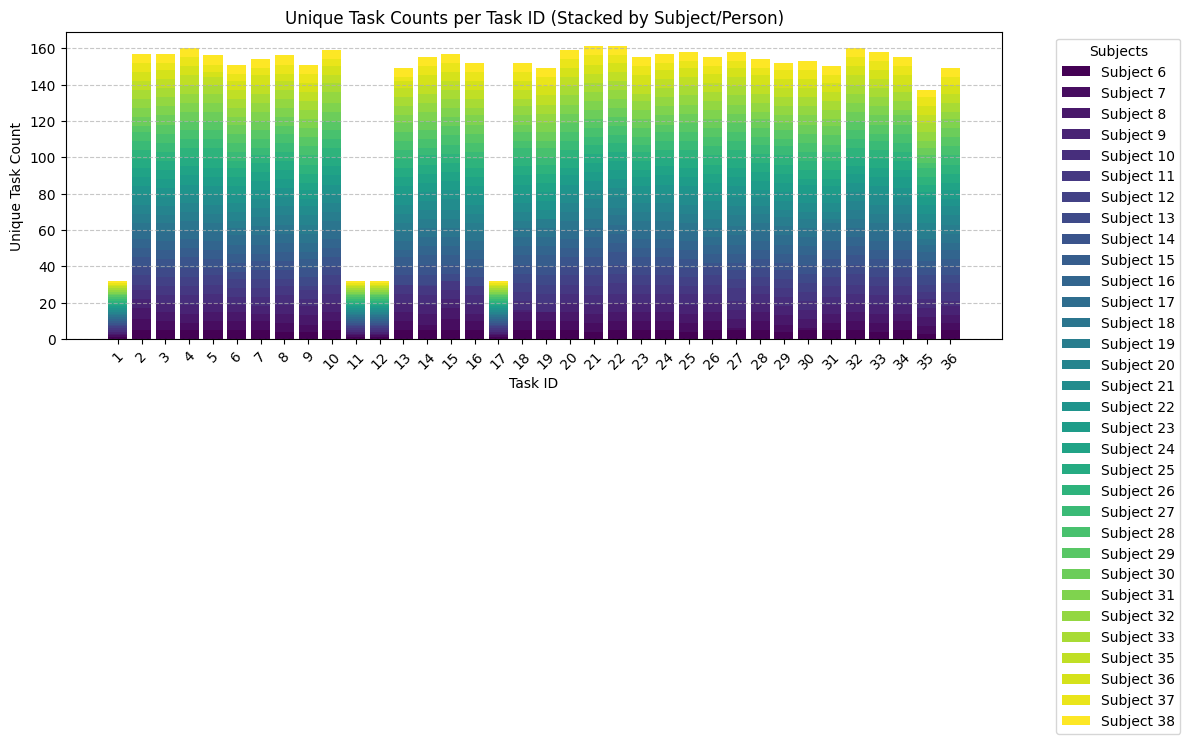

In [135]:

# Directory containing the CSV files
directory = "ProcessedData/MergedSubjectData"
# Dictionary to store unique task counts per subject
task_subject_counts = {}

# Iterate over files in the directory
for filename in os.listdir(directory):
    match = re.match(r'merged(\d{2})\.csv', filename)
    if match:
        subject_id = int(match.group(1))  # Extract subject number
        file_path = os.path.join(directory, filename)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Ensure necessary columns exist
        if 'Task ID' in df.columns and 'Repetition ID' in df.columns:
            # Get unique (Task ID, Repetition ID) pairs
            unique_task_reps = df[['Task ID', 'Repetition ID']].drop_duplicates()

            # Count occurrences per Task ID
            task_counts = unique_task_reps.groupby('Task ID').size()

            # Store counts in dictionary
            for task_id, count in task_counts.items():
                if task_id not in task_subject_counts:
                    task_subject_counts[task_id] = {}
                task_subject_counts[task_id][subject_id] = count

# Convert dictionary to DataFrame and fill missing values with 0
task_subject_df = pd.DataFrame(task_subject_counts).fillna(0).T  # Transpose for proper plotting
task_subject_df.sort_index(inplace=True)  # Sort tasks for better visualization

# Get unique subjects for stacked bar plot
subjects = sorted(set([subj for task in task_subject_counts.values() for subj in task.keys()]))

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Bottom array to stack bars
bottom = np.zeros(len(task_subject_df))

# Generate distinct colors for each subject
colors = plt.cm.viridis(np.linspace(0, 1, len(subjects)))

for i, subject in enumerate(subjects):
    values = task_subject_df.get(subject, np.zeros(len(task_subject_df)))  # Handle missing subjects
    bars = ax.bar(task_subject_df.index.astype(str), values, bottom=bottom, label=f'Subject {subject}', color=colors[i])
    bottom += values  # Update bottom for stacking

# Labels and title
plt.xlabel('Task ID')
plt.ylabel('Unique Task Count')
plt.title('Unique Task Counts per Task ID (Stacked by Subject/Person)')
plt.xticks(rotation=45)
plt.legend(title="Subjects", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

#### Okay now that we can see how many repetitions for each task across subjects was done, the sample seems pretty homogenic except for task 1,11,12 and 17. Before working on sample size and therefore resampling of the set, for the first part of the project I can just focus on training a simple fall detection neural network, the type of which ill discuss further ahead. 

#### For the feature engineering part, I was thinking of a particular architecture for the model. In fact I want to create a classification of movement before filtering falls, for improving the accuracy and generalization of the model. By this I mean that if a person is sitting down its fairly unlikely that he/she will fall because of a Stumble, or if he is walking it's unlikely that he/she will fall while trying to sit down. So my idea was to first mantain an analisys of the task being done, grouping them in subsets, and then associating each fall type to those subsets. Such as:

### Sitting-related tasks
	
    •	D11 – Sit on a chair for 30 seconds
	•	D12 – Sit on the sofa (back inclined) for 30 seconds
	•	D13 – Sit down to a chair normally, and get up normally
	•	D14 – Sit down to a chair quickly, and get up quickly
	•	D15 – Sit a moment, trying to get up, and collapse into a chair
	•	D16 – Stand, sit on the sofa, and get up normally
    •   D18 – Sit a moment, lie down to the bed normally, and get up normally
    •   D19 – Sit a moment, lie down to the bed quickly, and get up quickly

### Sitting-related falls
    •	F20 – Forward fall when trying to sit down
    •	F21 – Backward fall when trying to sit down
    •	F22 – Lateral fall when trying to sit down
    •	F23 – Forward fall when trying to get up
    •	F24 – Lateral fall when trying to get up
    •	F25 – Forward fall while sitting, caused by fainting
    •	F26 – Lateral fall while sitting, caused by fainting
    •	F27 – Backward fall while sitting, caused by fainting



### Walking-related tasks

	•	D06 – Walk normally with a turn (4m)
	•	D07 – Walk quickly with a turn (4m)
	•	D10 – Stumble while walking
    •	D20 – Walk upstairs and downstairs normally (5 steps)
    •	D21 – Walk upstairs and downstairs quickly (5 steps)

### Walking-related falls
	•	F28 – Vertical(forward) fall while walking caused by fainting
	•	F29 – Fall while walking, use of hands to dampen fall, caused by fainting
	•	F30 – Forward fall while walking caused by a trip
	•	F32 – Forward fall while walking caused by a slip
	•	F33 – Lateral fall while walking caused by a slip
	•	F34 – Backward fall while walking caused by a slip

### Jogging-related taks

    •	F31 – Forward fall while jogging caused by a trip

### Jogging-related falls

	•	D08 – Jog normally with a turn (4m)
	•	D09 – Jog quickly with a turn (4m)


#### I'll come back to this later on, for now I'll create 3 separate files, one with all the subjects merged data, one with the subjects fall data and finally one with the subject task data. Each file will contain an addinional column that states the subject number and then the the rows from each subject's file will be merged.

In [136]:
def merge_subject_data(input_dir, output_file, output_fall_file, output_task_file):
    all_data = []
    
    # Ensure input directory exists
    if not os.path.exists(input_dir):
        print(f"Error: Directory '{input_dir}' does not exist.")
        return
    # Define fall and task numeric values
    fall_tasks = {20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34}
    normal_tasks = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 35, 36}

    fall_data = []
    task_data = []
    
    # Process each file in the directory
    for filename in os.listdir(input_dir):
        match = re.match(r'merged(\d{2})\.csv', filename)        
        if match:
            subject_id = match.group(1)  # Extract subject number
            file_path = os.path.join(input_dir, filename)
            
            # Read CSV file
            try:
                df = pd.read_csv(file_path)
                df['subjectId'] = subject_id  # Add subjectId column

                # Append full dataset
                all_data.append(df)

                # Split into fall and normal task datasets
                fall_df = df[df["Task ID"].isin(fall_tasks)]
                task_df = df[df["Task ID"].isin(normal_tasks)]
                
                if not fall_df.empty:
                    fall_data.append(fall_df)
                
                if not task_df.empty:
                    task_data.append(task_df)
            
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    
    # Merge and save all data
    if all_data:
        merged_df = pd.concat(all_data, ignore_index=True)
        merged_df.to_csv(output_file, index=False)
        print(f"Merged data saved to {output_file}")

        # Save fall and normal task data separately
        if fall_data:
            merged_fall_df = pd.concat(fall_data, ignore_index=True)
            merged_fall_df.to_csv(output_fall_file, index=False)
            print(f"Fall data saved to {output_fall_file}")
        
        if task_data:
            merged_task_df = pd.concat(task_data, ignore_index=True)
            merged_task_df.to_csv(output_task_file, index=False)
            print(f"Task data saved to {output_task_file}")
    else:
        print("No valid CSV files found to merge.")

# Set directory and output file paths
input_directory = 'ProcessedData/MergedSubjectData'
output_filename = "ProcessedData/FinalData/FinalMergedData.csv"
output_fall_filename = 'ProcessedData/FinalData/FinalFallMergedData.csv'
output_task_filename = 'ProcessedData/FinalData/FinalTaskMergedData.csv'

# Run the merging function
merge_subject_data(input_directory, output_filename, output_fall_filename, output_task_filename)

Merged data saved to ProcessedData/FinalData/FinalMergedData.csv
Fall data saved to ProcessedData/FinalData/FinalFallMergedData.csv
Task data saved to ProcessedData/FinalData/FinalTaskMergedData.csv


#### The task file will fist be used to identify the task being done and used in the feature engineering to train a model that based on the task resticts the identification of the fall to a specific subset a previously described. 

#### For now I will focus on the data visualization for the fall file

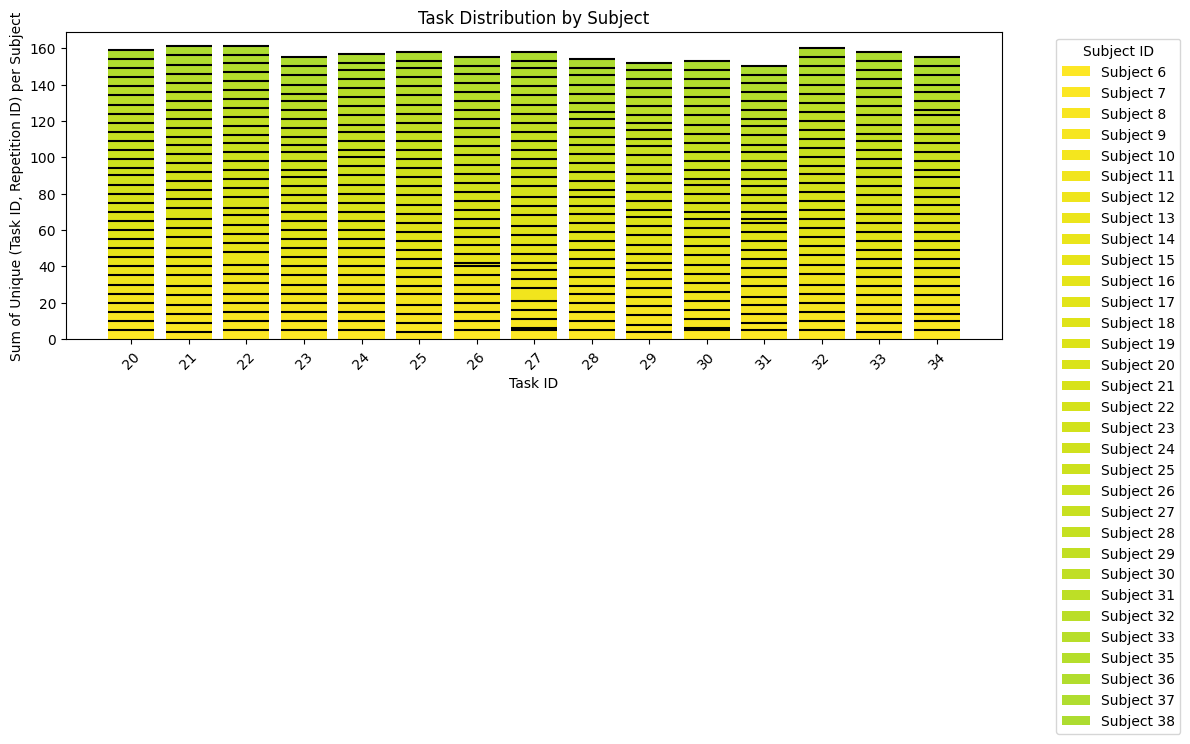

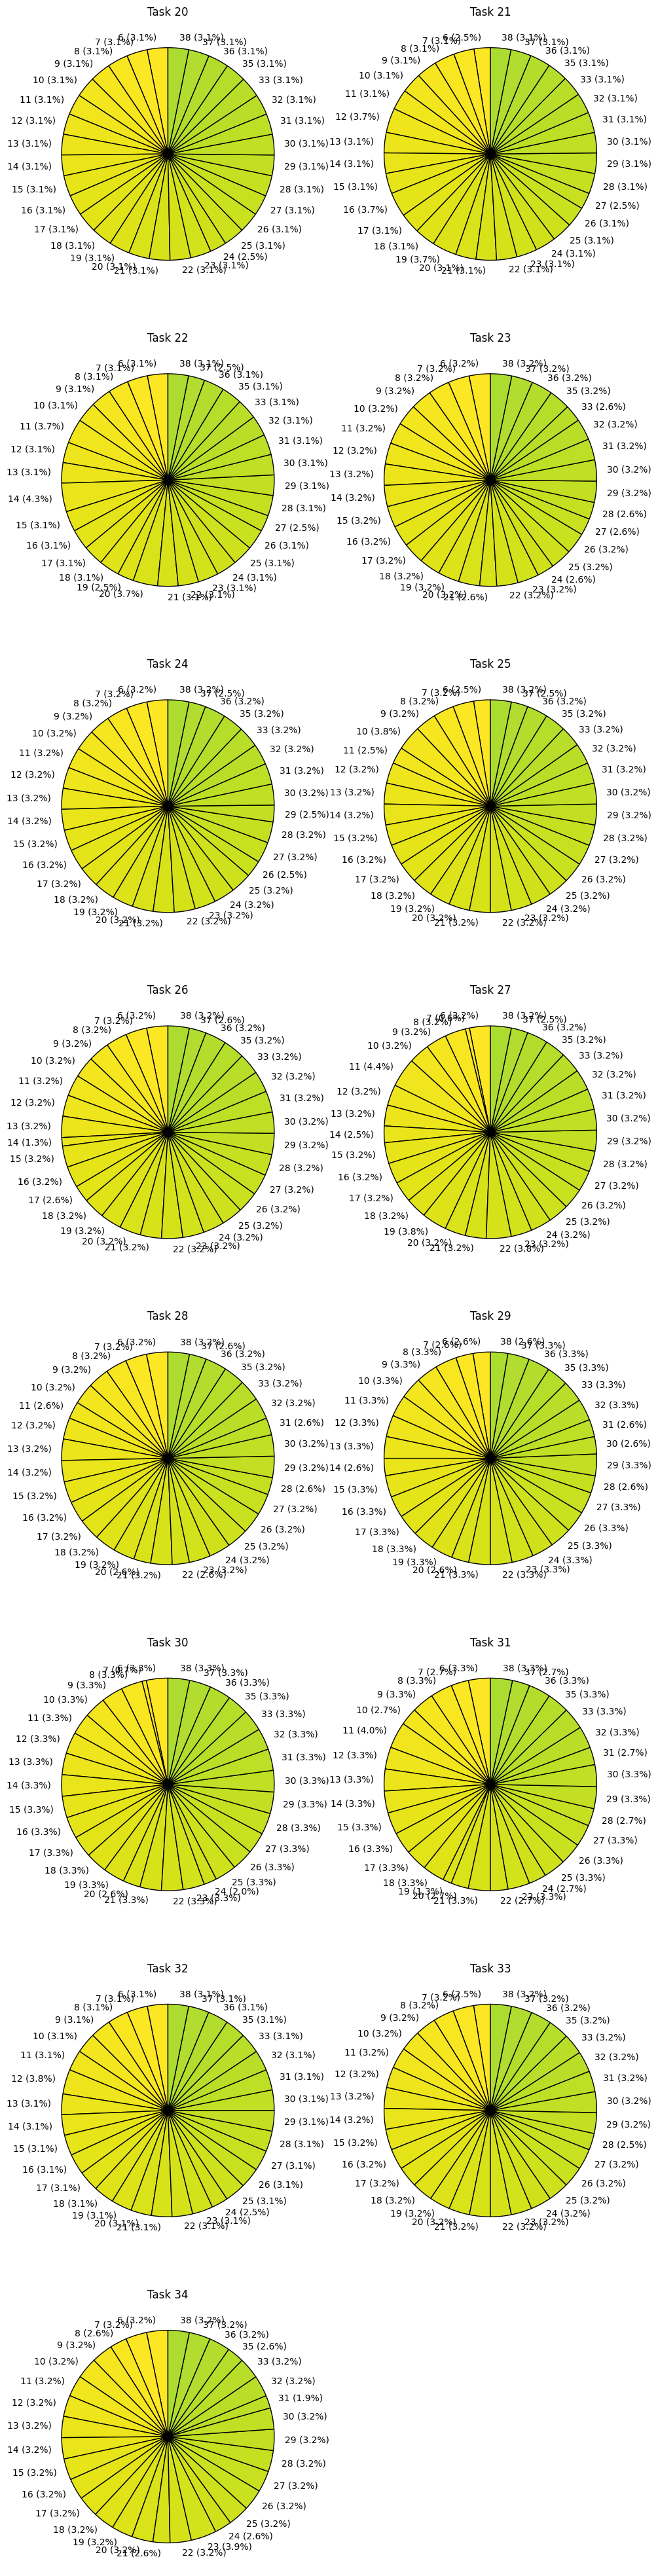

    Task ID  sum_count
0        20        159
1        21        161
2        22        161
3        23        155
4        24        157
5        25        158
6        26        155
7        27        158
8        28        154
9        29        152
10       30        153
11       31        150
12       32        160
13       33        158
14       34        155


In [137]:
# Load CSV file
file_path = "ProcessedData/FinalData/FinalFallMergedData.csv"  
df = pd.read_csv(file_path)

# Count unique (Task ID, Repetition ID) pairs per subject
unique_tasks = df.groupby(["subjectId", "Task ID", "Repetition ID"]).size().reset_index().drop(columns=0)

# Aggregate counts per Task ID and subject
task_counts = unique_tasks.groupby(["Task ID", "subjectId"]).size().reset_index(name="count")

# Calculate total count per Task ID
total_task_counts = task_counts.groupby("Task ID")["count"].sum().reset_index(name="total_count")

# Merge back to calculate subject percentage contribution
task_counts = task_counts.merge(total_task_counts, on="Task ID")
task_counts["percentage"] = task_counts["count"] / task_counts["total_count"] * 100  # Convert to percentage

# ---------------- BAR CHART ---------------- #
fig, ax = plt.subplots(figsize=(12, 6))

# Unique Task IDs
task_ids = sorted(task_counts["Task ID"].unique())  # Ensure the Task IDs are sorted
bottom = {task_id: 0 for task_id in task_ids}

# Get unique subjects
subjects = task_counts["subjectId"].unique()
colors = plt.cm.viridis_r(range(len(subjects)))  # Generate colors for subjects

# Draw bars and store end points for black lines
segment_endings = []  # Stores (x, y) coordinates for black lines

for subject, color in zip(subjects, colors):
    subset = task_counts[task_counts["subjectId"] == subject]
    
    bars = ax.bar(
        subset["Task ID"], subset["count"], bottom=[bottom[tid] for tid in subset["Task ID"]],
        label=f"Subject {subject}", color=color
    )
    
    # Store segment end positions for black lines
    for rect, tid in zip(bars, subset["Task ID"]):
        new_height = bottom[tid] + rect.get_height()
        segment_endings.append((tid, new_height))
        bottom[tid] = new_height  # Update bottom height for stacking

# Draw black horizontal lines at segment boundaries
for tid, height in segment_endings:
    ax.hlines(y=height, xmin=tid - 0.4, xmax=tid + 0.4, color="black", linewidth=1.5)

# Labels and legend
ax.set_xlabel("Task ID")
ax.set_ylabel("Sum of Unique (Task ID, Repetition ID) per Subject")
ax.set_title("Task Distribution by Subject")

# Ensure every Task ID is labeled
ax.set_xticks(task_ids)
ax.set_xticklabels(task_ids, rotation=45)  # Rotate for better readability

ax.legend(title="Subject ID", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# ---------------- PIE CHARTS ---------------- #
num_tasks = len(task_ids)
cols = 2  # Set number of columns per row
rows = math.ceil(num_tasks / cols)  # Compute number of rows

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 5, rows * 5))

# Flatten axes for easy iteration if there are multiple rows
axes = axes.flatten()

for i, task_id in enumerate(task_ids):
    ax = axes[i]
    task_subset = task_counts[task_counts["Task ID"] == task_id]
    subject_labels = [f"{subj} ({perc:.1f}%)" for subj, perc in zip(task_subset["subjectId"], task_subset["percentage"])]
    sizes = task_subset["percentage"]

    ax.pie(
        sizes, labels=subject_labels, autopct='', colors=[plt.cm.viridis_r(i) for i in range(len(sizes))],
        startangle=90, wedgeprops={"edgecolor": "black"}
    )
    ax.set_title(f"Task {task_id}")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Group by Task ID and count unique (Task ID, Repetition ID) pairs
task_sums = unique_tasks.groupby("Task ID").size().reset_index(name="sum_count")

# Print each Task ID and its sum count
print(task_sums)

#### the set seems to be pretty homegenous, furthermore the data is temporal data from sensors which is obtained in a sequential manner for each subject-task-repetition, the data being analised is sensor data from a total of 10 features usable for model training (AccX, AccY, AccZ, GyrX, GyrY, GyrZ, EulerX, EulerY, EulerZ, isFalling). For this reason I was thinking of using an RNN. However, the action of a fall observed from the data sets, seems to occur over multiple frames, so my model will have to keep track of a multitude of previous timesteps, in addition there are 1725409 rows of data. This would make the training process of the rnn extremely slow and it could cause inaccuracies due to gradients vanishing and or "exploding". I therfore chose to use a CNN which should be a better fit for the training data available.

#### I will now check for correlation between the features in order to remove unecessary complexity in the model training

Correlation Matrix:
                AccX      AccY      AccZ      GyrX      GyrY      GyrZ  \
AccX       1.000000  0.117056 -0.065478 -0.012901  0.074939 -0.334311   
AccY       0.117056  1.000000 -0.157969  0.052914  0.025697 -0.018947   
AccZ      -0.065478 -0.157969  1.000000  0.237439 -0.000234  0.015794   
GyrX      -0.012901  0.052914  0.237439  1.000000 -0.031717  0.075242   
GyrY       0.074939  0.025697 -0.000234 -0.031717  1.000000 -0.239757   
GyrZ      -0.334311 -0.018947  0.015794  0.075242 -0.239757  1.000000   
EulerX    -0.121438 -0.413015  0.339156  0.067131 -0.006200  0.001116   
EulerY     0.848870  0.105163 -0.026225 -0.005959  0.094426 -0.182828   
EulerZ     0.054694  0.059314 -0.029870 -0.024487  0.119776 -0.104712   
isFalling  0.003864 -0.011487 -0.077679 -0.147411  0.042895 -0.058884   

             EulerX    EulerY    EulerZ  isFalling  
AccX      -0.121438  0.848870  0.054694   0.003864  
AccY      -0.413015  0.105163  0.059314  -0.011487  
AccZ       0.339

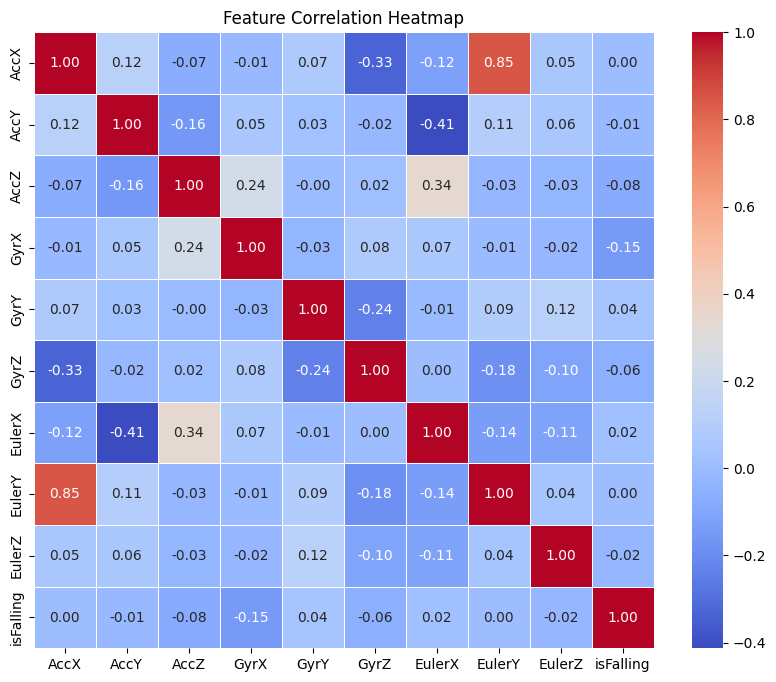

In [138]:

file_path = "ProcessedData/FinalData/FinalFallMergedData.csv" 
df = pd.read_csv(file_path)

# Select relevant columns
features = ["AccX", "AccY", "AccZ", "GyrX", "GyrY", "GyrZ", "EulerX", "EulerY", "EulerZ", "isFalling"]
df_selected = df[features]

# Compute correlation matrix
correlation_matrix = df_selected.corr()

# Print correlation matrix
print("Correlation Matrix:\n", correlation_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

#### the only correlation that becomes apperent is the EulerY to AccX. I will therefore check which one of the two has a lower correlation score using a simple randomforestclassifier

In [140]:
print(correlation_matrix["isFalling"].sort_values(ascending=False))

isFalling    1.000000
GyrY         0.042895
EulerX       0.021969
AccX         0.003864
EulerY       0.001256
AccY        -0.011487
EulerZ      -0.024464
GyrZ        -0.058884
AccZ        -0.077679
GyrX        -0.147411
Name: isFalling, dtype: float64


#### Accx seems to be 3 times as important as EulerY so i will drop Euler Y

In [141]:
df.drop(columns=["EulerY"], inplace=True)
output_file = "ProcessedData/FinalData/FinalFallMergedData_NoEulerY.csv"
df.to_csv(output_file, index=False)


#### Now that we have clean data set without correlation it is time to start training the model, I will try and train both a cnn and a LSTM and see which one performs the best.

### Data kfolding, epochs and batching

#### I will now check first with a cnn model the best amount of epochs to use and batching size, by creating the appropriate graphs through methods genrated by chatgbt. The graphs should aid in identifying the breaking point where higher batch or epoch size would not bring benefit or cause overfitting to the training data set.



Training with batch size 8...



/Users/lorenzolucchini/miniconda3/envs/Assignment2/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
172536/172536 ━━━━━━━━━━━━━━━━━━━━ 151s 874us/step - accuracy: 0.9686 - loss: 0.0840 - val_accuracy: 0.9769 - val_loss: 0.0611
Epoch 2/10
172536/172536 ━━━━━━━━━━━━━━━━━━━━ 153s 884us/step - accuracy: 0.9766 - loss: 0.0641 - val_accuracy: 0.9769 - val_loss: 0.0666
Epoch 3/10
172536/172536 ━━━━━━━━━━━━━━━━━━━━ 161s 934us/step - accuracy: 0.9767 - loss: 0.0638 - val_accuracy: 0.9786 - val_loss: 0.0559
Epoch 4/10
172536/172536 ━━━━━━━━━━━━━━━━━━━━ 159s 920us/step - accuracy: 0.9773 - loss: 0.0625 - val_accuracy: 0.9788 - val_loss: 0.0577
Epoch 5/10
172536/172536 ━━━━━━━━━━━━━━━━━━━━ 158s 914us/step - accuracy: 0.9774 - loss: 0.0626 - val_accuracy: 0.9787 - val_loss: 0.0562
Epoch 6/10
172536/172536 ━━━━━━━━━━━━━━━━━━━━ 160s 925us/step - accuracy: 0.9772 - loss: 0.0624 - val_accuracy: 0.9782 - val_loss: 0.0580

Training with batch size 16...

Epoch 1/10
86268/86268 ━━━━━━━━━━━━━━━━━━━━ 89s 1ms/step - accuracy: 0.9696 - loss: 0.0803 - val_accuracy: 0.9778 - val_loss: 0.0604
Epoch 

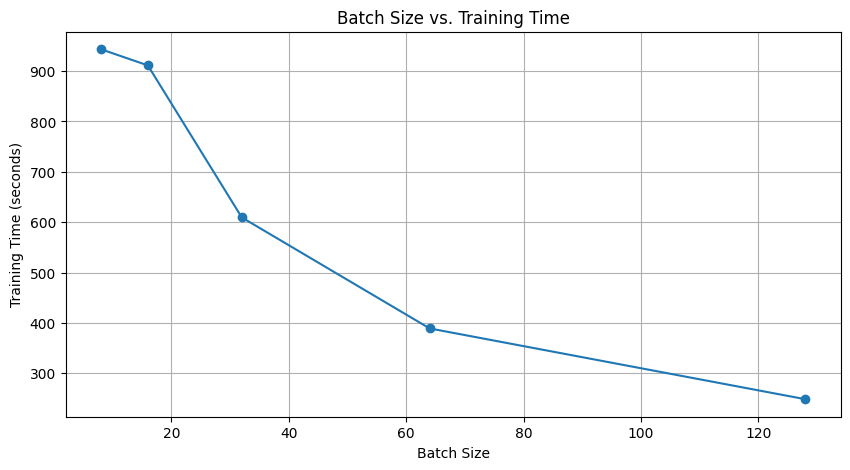

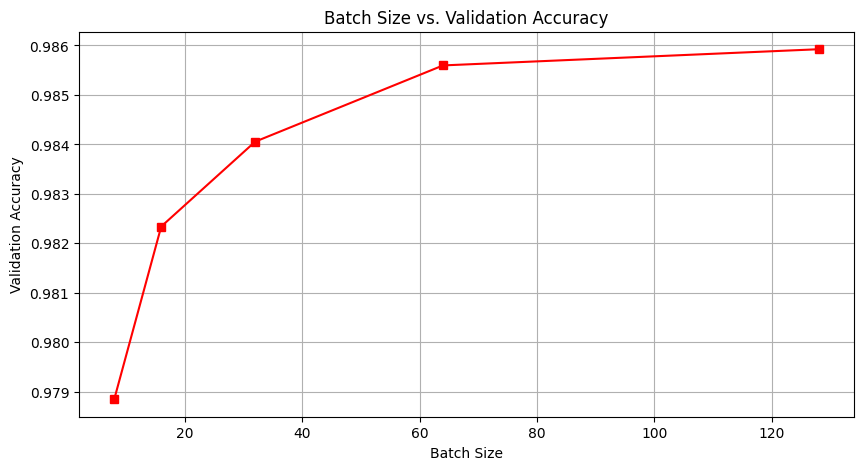

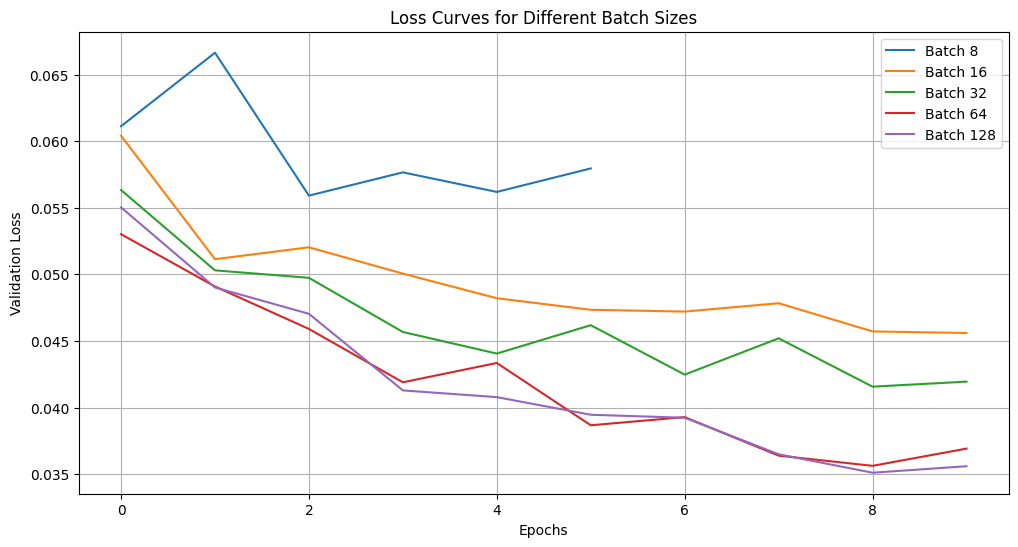

In [145]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
file_path = "ProcessedData/FinalData/FinalFallMergedData_NoEulerY.csv"
df = pd.read_csv(file_path)

# Define features and target variable
features = ["AccX", "AccY", "AccZ", "GyrX", "GyrY", "GyrZ", "EulerX", "EulerZ"]  # Removed EulerY
target = "isFalling"

# Handle missing values (fill with mean)
df.fillna(df.mean(), inplace=True)

# Normalize feature values
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

# Reshape X for CNN input: (samples, time_steps, features)
time_steps = 50  # Define time window (adjust based on dataset size)
num_features = len(features)

# Convert time-series data into 3D format
def create_time_series_data(X, y, time_steps):
    X_ts, y_ts = [], []
    for i in range(len(X) - time_steps):
        X_ts.append(X[i:i + time_steps])  # Create time window
        y_ts.append(y[i + time_steps])    # Predict next value
    return np.array(X_ts), np.array(y_ts)

y = df[target].values
X, y = create_time_series_data(X, y, time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CNN model
def create_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, num_features)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Batch sizes to test
batch_sizes = [8, 16, 32, 64, 128]

# Store results
training_times = []
val_accuracies = []
history_records = {}

# Train model with different batch sizes
for batch_size in batch_sizes:
    print(f"\nTraining with batch size {batch_size}...\n")

    model = create_cnn_model()  # Create fresh model for each run

    start_time = time.time()
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test),
                        epochs=10,  # Increased max epochs, but will stop early if needed
                        batch_size=batch_size, 
                        verbose=1, 
                        callbacks=[early_stopping])  # Early stopping added
    end_time = time.time()

    # Store results
    training_times.append(end_time - start_time)
    val_accuracies.append(max(history.history['val_accuracy']))  # Best validation accuracy
    history_records[batch_size] = history

# Plot batch size vs training time
plt.figure(figsize=(10,5))
plt.plot(batch_sizes, training_times, marker='o', linestyle='-')
plt.xlabel("Batch Size")
plt.ylabel("Training Time (seconds)")
plt.title("Batch Size vs. Training Time")
plt.grid()
plt.show()

# Plot batch size vs validation accuracy
plt.figure(figsize=(10,5))
plt.plot(batch_sizes, val_accuracies, marker='s', linestyle='-', color='red')
plt.xlabel("Batch Size")
plt.ylabel("Validation Accuracy")
plt.title("Batch Size vs. Validation Accuracy")
plt.grid()
plt.show()

# Plot loss curves for different batch sizes
plt.figure(figsize=(12,6))
for batch_size, history in history_records.items():
    plt.plot(history.history['val_loss'], label=f'Batch {batch_size}')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Loss Curves for Different Batch Sizes")
plt.legend()
plt.grid()
plt.show()

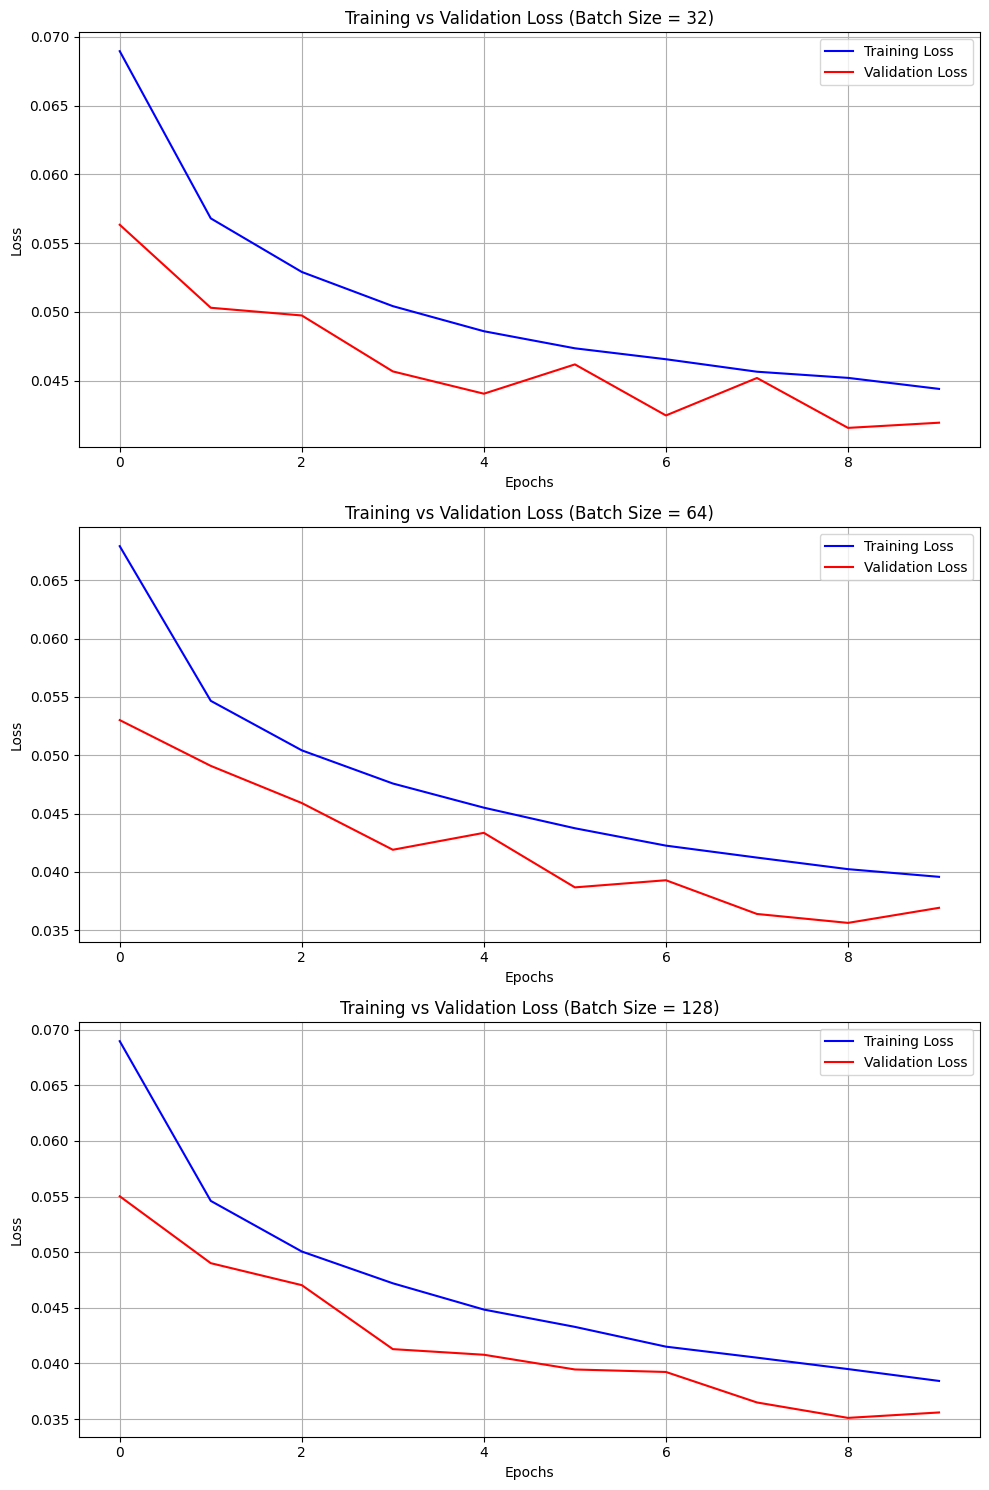

In [146]:
# Define batch sizes to plot
batch_sizes = [32, 64, 128]

# Create figure for subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Loop through each batch size and plot
for i, batch_size in enumerate(batch_sizes):
    if batch_size in history_records:
        batch_history = history_records[batch_size]

        # Plot training and validation loss
        axes[i].plot(batch_history.history['loss'], label='Training Loss', color='blue')
        axes[i].plot(batch_history.history['val_loss'], label='Validation Loss', color='red')

        # Labels and title
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel("Loss")
        axes[i].set_title(f"Training vs Validation Loss (Batch Size = {batch_size})")
        axes[i].legend()
        axes[i].grid()
    else:
        axes[i].text(0.5, 0.5, f"History for batch size {batch_size} not found", 
                     horizontalalignment='center', verticalalignment='center', fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### There is no clear indication of overfitting, and the curve of training loss vs validation loss looks like it's still decreasing, I will therefore create another code snipped checking further epochs (from 10 to 100 with 10 ecpochs steps) and a batch of 128


Training with 10 epochs...



/Users/lorenzolucchini/miniconda3/envs/Assignment2/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
10784/10784 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9675 - loss: 0.0846 - val_accuracy: 0.9773 - val_loss: 0.0578
Epoch 2/10
10784/10784 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9779 - loss: 0.0573 - val_accuracy: 0.9804 - val_loss: 0.0502
Epoch 3/10
10784/10784 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9797 - loss: 0.0521 - val_accuracy: 0.9808 - val_loss: 0.0474
Epoch 4/10
10784/10784 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9810 - loss: 0.0484 - val_accuracy: 0.9823 - val_loss: 0.0431
Epoch 5/10
10784/10784 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9820 - loss: 0.0462 - val_accuracy: 0.9835 - val_loss: 0.0403
Epoch 6/10
10784/10784 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9826 - loss: 0.0445 - val_accuracy: 0.9839 - val_loss: 0.0401
Epoch 7/10
10784/10784 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9832 - loss: 0.0427 - val_accuracy: 0.9844 - val_loss: 0.0385
Epoch 8/10
10784/10784 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 

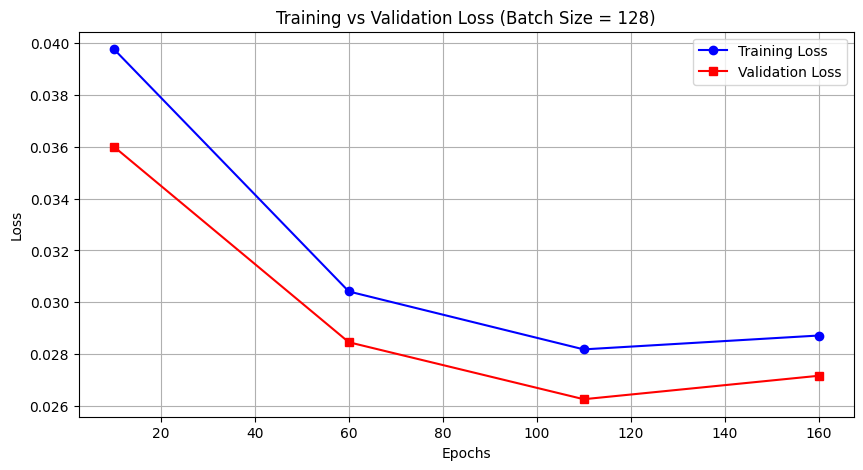

In [148]:


# Load dataset
file_path = "ProcessedData/FinalData/FinalFallMergedData_NoEulerY.csv"
df = pd.read_csv(file_path)

# Define features and target variable
features = ["AccX", "AccY", "AccZ", "GyrX", "GyrY", "GyrZ", "EulerX", "EulerZ"]  # Removed EulerY
target = "isFalling"

# Handle missing values (fill with mean)
df.fillna(df.mean(), inplace=True)

# Normalize feature values
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

# Reshape X for CNN input: (samples, time_steps, features)
time_steps = 50  # Define time window
num_features = len(features)

# Convert time-series data into 3D format
def create_time_series_data(X, y, time_steps):
    X_ts, y_ts = [], []
    for i in range(len(X) - time_steps):
        X_ts.append(X[i:i + time_steps])  # Create time window
        y_ts.append(y[i + time_steps])    # Predict next value
    return np.array(X_ts), np.array(y_ts)

y = df[target].values
X, y = create_time_series_data(X, y, time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CNN model
def create_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, num_features)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Epochs to test
epoch_values = list(range(10, 210, 50)) 
training_losses = []
validation_losses = []

# Train model for increasing epochs
for epochs in epoch_values:
    print(f"\nTraining with {epochs} epochs...\n")

    model = create_cnn_model()  # Create fresh model

    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=128, verbose=1, callbacks=[early_stopping])

    # Store final loss at the last epoch
    training_losses.append(history.history['loss'][-1])  # Last training loss
    validation_losses.append(history.history['val_loss'][-1])  # Last validation loss

# Plot training vs validation loss over increasing epochs
plt.figure(figsize=(10, 5))
plt.plot(epoch_values, training_losses, marker='o', linestyle='-', label="Training Loss", color="blue")
plt.plot(epoch_values, validation_losses, marker='s', linestyle='-', label="Validation Loss", color="red")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Batch Size = 128)")
plt.legend()
plt.grid()
plt.show()

#### The graph identifies 110 as the lowest pair of validation and testing loss before an increase which could indicate an overfitting. I will use 110 epochs and 128 batch size. However, since the step was 50 epochs there might be a lower value before, so ill integrate early stoppage in the training of my model to avoid a possible overfit at 110 epochs. To further make sure that the overfitting is kept as low as possible I will be using kfold to divide the data in 3 parts trainig, testing and validation.

#### I need to create the kfold based on individual subject-task-repetition, as the data is sequential and therefore makes sense if the repetition of a task is analized as a whole. 


#### Furthermore, I was able to maintain the TimeStamp(s) comlumn. This is extemely helpful as I think that since it is sensor data, the best feature of engineering for this model is to use time series. So I will reshape the CNN input to keep track of time series by creating sliding windows. I chose a window size of 50 to begin with, I'll try and chage this further ahead.

#### Finally at each epoch iteration i will save the precision, recall, f1-score, support scores so then generate 4 graphs to visualize the overall performace of each epoch in those areas, with another graph rapresenting the training loss vs validation loss to establish where the epoch start 

### The following code was generated in collaboration with chatgpt to meet the requirements previously described, I chose a window si

/Users/lorenzolucchini/miniconda3/envs/Assignment2/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
7597/7597 ━━━━━━━━━━━━━━━━━━━━ 5s 615us/step
 - val_precision: 0.8748, val_recall: 0.8032, val_f1_score: 0.8375
8787/8787 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9502 - loss: 0.1267 - val_accuracy: 0.9683 - val_loss: 0.0889
Epoch 2/50
7597/7597 ━━━━━━━━━━━━━━━━━━━━ 5s 710us/step
 - val_precision: 0.8172, val_recall: 0.8977, val_f1_score: 0.8556
8787/8787 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9708 - loss: 0.0750 - val_accuracy: 0.9692 - val_loss: 0.0823
Epoch 3/50
7597/7597 ━━━━━━━━━━━━━━━━━━━━ 5s 697us/step
 - val_precision: 0.8882, val_recall: 0.8353, val_f1_score: 0.8610
8787/8787 ━━━━━━━━━━━━━━━━━━━━ 77s 9ms/step - accuracy: 0.9742 - loss: 0.0664 - val_accuracy: 0.9726 - val_loss: 0.0703
Epoch 4/50
7597/7597 ━━━━━━━━━━━━━━━━━━━━ 5s 641us/step
 - val_precision: 0.8972, val_recall: 0.8303, val_f1_score: 0.8624
8787/8787 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9758 - loss: 0.0615 - val_accuracy: 0.9731 - val_loss: 0.0725
Epoch 5/50
7597/7597 ━━━━━━━

Test Set - Loss: 0.054417505860328674, Accuracy: 0.979221522808075


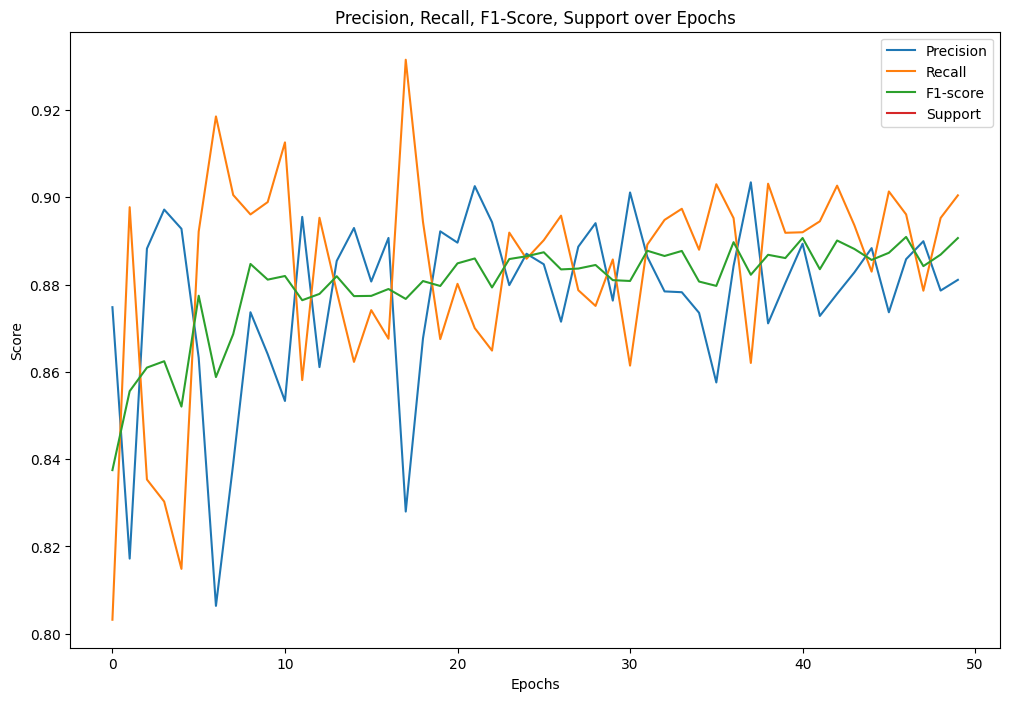

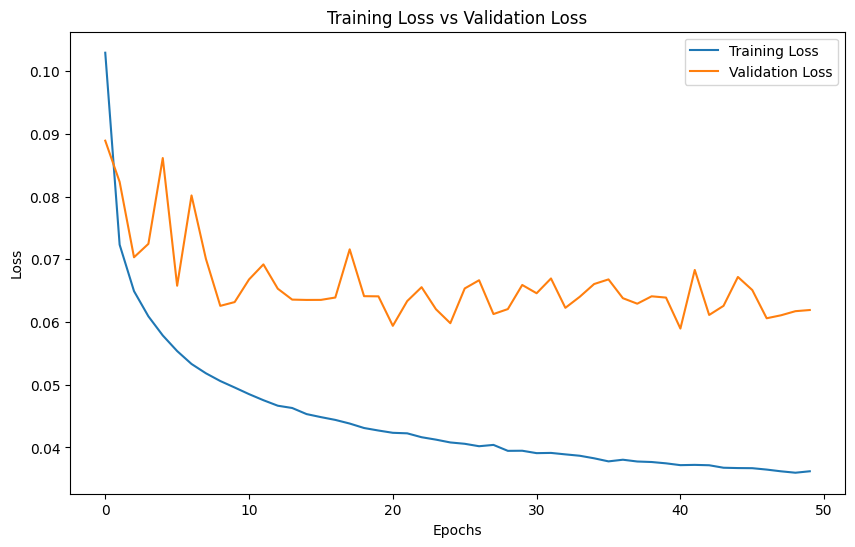

In [33]:
# Load dataset
file_path = "ProcessedData/FinalData/FinalFallMergedData_NoEulerY.csv"
df = pd.read_csv(file_path)

# Features and target
features = ["AccX", "AccY", "AccZ", "GyrX", "GyrY", "GyrZ", "EulerX", "EulerZ"]
target = "isFalling"
window_size = 50  # Define sequence length

# Group by unique trials (subjectId, Task ID, Repetition ID) to maintain sequence continuity
unique_trials = df.groupby(["subjectId", "Task ID", "Repetition ID"]).size().reset_index()[["subjectId", "Task ID", "Repetition ID"]]

# Split into 70% training, 15% test, and 15% validation
train_idx, temp_idx = train_test_split(unique_trials, test_size=0.30, random_state=42)
test_idx, val_idx = train_test_split(temp_idx, test_size=0.50, random_state=42)  # Split remaining 30% into 15% test and 15% validation

# Create datasets based on the indices
def get_data_from_indices(indices):
    selected_trials = indices
    merged_data = df.merge(selected_trials, on=["subjectId", "Task ID", "Repetition ID"], how="inner")
    return merged_data

train_data = get_data_from_indices(train_idx)
test_data = get_data_from_indices(test_idx)
val_data = get_data_from_indices(val_idx)

# Function to create sliding windows
def create_time_series_data(data, features, target, window_size):
    X, y = [], []
    
    # Ensure sorting by time
    data = data.sort_values(by=["subjectId", "Task ID", "Repetition ID", "TimeStamp(s)"])
    
    # Group by unique trials
    grouped = data.groupby(["subjectId", "Task ID", "Repetition ID"])
    
    for _, group in grouped:
        values = group[features].values
        labels = group[target].values
        
        # Create rolling sequences
        for i in range(len(values) - window_size):
            X.append(values[i:i + window_size])  # Get window of `window_size`
            y.append(labels[i + window_size - 1])  # Assign last value in window as label
    
    return np.array(X), np.array(y)

# Create sequences
X_train, y_train = create_time_series_data(train_data, features, target, window_size)
X_test, y_test = create_time_series_data(test_data, features, target, window_size)
X_val, y_val = create_time_series_data(val_data, features, target, window_size)

# CNN Model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Callback for computing F1-score, precision, recall, and support
class MetricsCallback(Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val
        self.history = {"precision": [], "recall": [], "f1_score": [], "support": []}
    
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val)
        y_pred = (y_pred > 0.5).astype(int)
        precision, recall, f1, support = precision_recall_fscore_support(self.y_val, y_pred, average='binary')
        
        self.history["precision"].append(precision)
        self.history["recall"].append(recall)
        self.history["f1_score"].append(f1)
        self.history["support"].append(support)
        
        print(f" - val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1_score: {f1:.4f}")

# Train model
input_shape = (window_size, len(features))
model = create_cnn_model(input_shape)

metrics_callback = MetricsCallback(X_val, y_val)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    verbose=1,
    callbacks=[metrics_callback]
)

# Evaluate on test set
eval_results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Set - Loss: {eval_results[0]}, Accuracy: {eval_results[1]}")

# Save model
model.save("Models/fall_detection_cnn.h5")

# Plot metrics
epochs_range = range(len(metrics_callback.history["precision"]))
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, metrics_callback.history["precision"], label='Precision')
plt.plot(epochs_range, metrics_callback.history["recall"], label='Recall')
plt.plot(epochs_range, metrics_callback.history["f1_score"], label='F1-score')
plt.plot(epochs_range, metrics_callback.history["support"], label='Support')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-Score, Support over Epochs")
plt.legend()
plt.show()

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.show()

#### I will now evaluate the speed at which the 50 epoch 128 batch cnn is able to detect the fall in ms.

In [34]:
# Predict over the test set
cnn_val_y_pred = (model.predict(X_val) > 0.5).astype(int)

# Find first actual fall timestamp
fall_indices_actual = np.where(y_val == 1)[0]
fall_indices_predicted = np.where(cnn_val_y_pred == 1)[0]

if len(fall_indices_actual) > 0 and len(fall_indices_predicted) > 0:
    T_fall_actual = fall_indices_actual[0]  # First real fall index
    T_fall_detected = fall_indices_predicted[0]  # First detected fall index

    detection_delay_steps = T_fall_detected - T_fall_actual  # Time steps delay
    detection_delay_time = detection_delay_steps * 0.01  # Convert to seconds

    print(f"Detection Delay: {detection_delay_steps} time steps")
    print(f"Detection Delay in Time: {detection_delay_time:.3f} seconds")
else:
    print("⚠️ No fall detected in the test set!")

7597/7597 ━━━━━━━━━━━━━━━━━━━━ 5s 626us/step
Detection Delay: 5 time steps
Detection Delay in Time: 0.050 seconds


#### I can retrain the cnn by decreasing the window size and check if it alters the detection delay. Furthermore based on the prious graphs it seems that 20 epochs is enough to have a precise Model without to go to 50 epochs, I will therefore retrain the model with 20 window frame size and up to 20 epochs.

In [ ]:
# Train model
input_shape = (window_size, len(features))
model20epoc = create_cnn_model(input_shape)

epoc20metrics_callback = MetricsCallback(X_val, y_val)

history20epoc = model20epoc.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,
    verbose=1,
    callbacks=[epoc20metrics_callback]
)


Epoch 1/20
7597/7597 ━━━━━━━━━━━━━━━━━━━━ 5s 667us/step
 - val_precision: 0.8524, val_recall: 0.8057, val_f1_score: 0.8284
8787/8787 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9502 - loss: 0.1266 - val_accuracy: 0.9661 - val_loss: 0.0890
Epoch 2/20
7597/7597 ━━━━━━━━━━━━━━━━━━━━ 4s 588us/step
 - val_precision: 0.8702, val_recall: 0.8524, val_f1_score: 0.8612
8787/8787 ━━━━━━━━━━━━━━━━━━━━ 72s 8ms/step - accuracy: 0.9707 - loss: 0.0754 - val_accuracy: 0.9721 - val_loss: 0.0725
Epoch 3/20
7597/7597 ━━━━━━━━━━━━━━━━━━━━ 4s 564us/step
 - val_precision: 0.8205, val_recall: 0.9042, val_f1_score: 0.8603
8787/8787 ━━━━━━━━━━━━━━━━━━━━ 74s 8ms/step - accuracy: 0.9740 - loss: 0.0661 - val_accuracy: 0.9701 - val_loss: 0.0768
Epoch 4/20
7597/7597 ━━━━━━━━━━━━━━━━━━━━ 4s 568us/step
 - val_precision: 0.8756, val_recall: 0.8539, val_f1_score: 0.8646
8787/8787 ━━━━━━━━━━━━━━━━━━━━ 342s 39ms/step - accuracy: 0.9763 - loss: 0.0608 - val_accuracy: 0.9728 - val_loss: 0.0732
Epoch 5/20
7597/7597 ━━━━━

AttributeError: 'History' object has no attribute 'evaluate'

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 5s 662us/step - accuracy: 0.9763 - loss: 0.0681
Test Set - Loss: 0.058176085352897644, Accuracy: 0.979412853717804

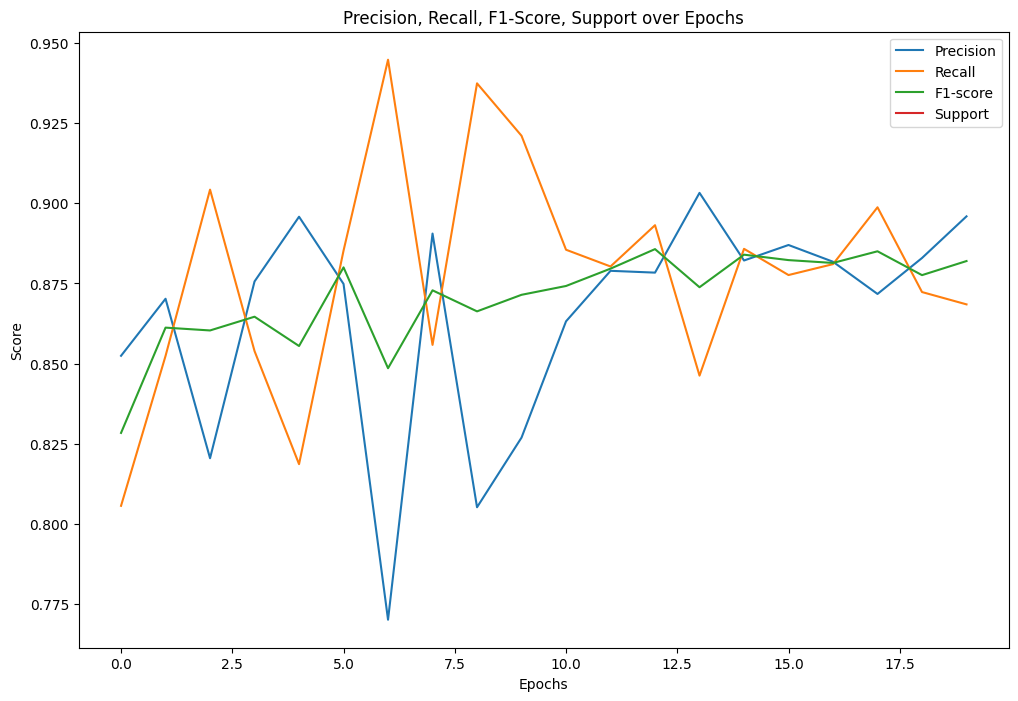

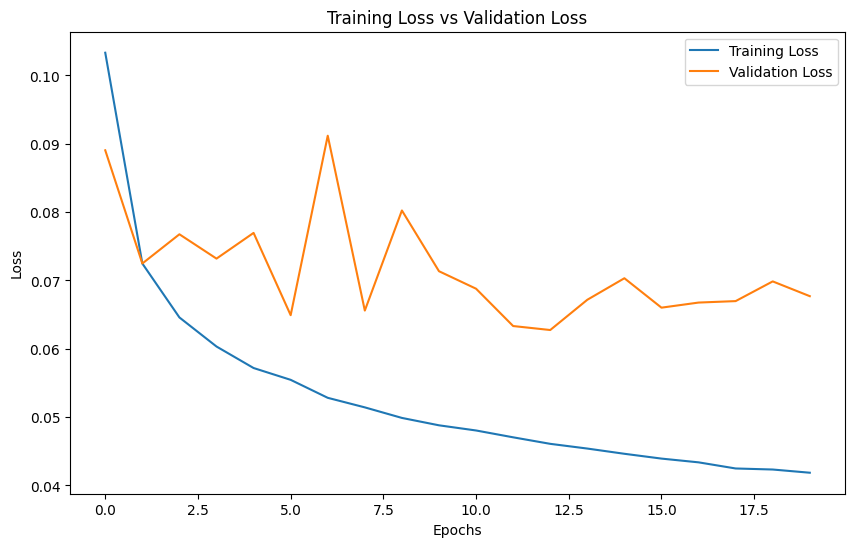

In [39]:

# Evaluate on test set (Fixed)
eval20epoc_results = model20epoc.evaluate(X_test, y_test, verbose=1)
print(f"Test Set - Loss: {eval20epoc_results[0]}, Accuracy: {eval20epoc_results[1]}")

# Save model
model20epoc.save("Models/fall_detection_cnn20epoc.h5")

# Plot metrics (Fixed epochs_range)
epochs_range = range(len(epoc20metrics_callback.history["precision"]))

plt.figure(figsize=(12, 8))
plt.plot(epochs_range, epoc20metrics_callback.history["precision"], label='Precision')
plt.plot(epochs_range, epoc20metrics_callback.history["recall"], label='Recall')
plt.plot(epochs_range, epoc20metrics_callback.history["f1_score"], label='F1-score')
plt.plot(epochs_range, epoc20metrics_callback.history["support"], label='Support')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-Score, Support over Epochs")
plt.legend()
plt.show()

# Plot training vs validation loss (Fixed)
plt.figure(figsize=(10, 6))
plt.plot(history20epoc.history['loss'], label='Training Loss')
plt.plot(history20epoc.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend()
plt.show()

In [40]:
# Predict over the test set
cnn20_val_y_pred = (model20epoc.predict(X_val) > 0.5).astype(int)

# Find first actual fall timestamp
fall20_indices_actual = np.where(y_val == 1)[0]
fall20_indices_predicted = np.where(cnn20_val_y_pred == 1)[0]

if len(fall20_indices_actual) > 0 and len(fall20_indices_predicted) > 0:
    T20_fall_actual = fall20_indices_actual[0]  # First real fall index
    T20_fall_detected = fall20_indices_predicted[0]  # First detected fall index

    detection20_delay_steps = T20_fall_detected - T20_fall_actual  # Time steps delay
    detection20_delay_time = detection20_delay_steps * 0.01  # Convert to seconds

    print(f"Detection Delay: {detection20_delay_steps} time steps")
    print(f"Detection Delay in Time: {detection20_delay_time:.3f} seconds")
else:
    print("⚠️ No fall detected in the test set!")

7597/7597 ━━━━━━━━━━━━━━━━━━━━ 4s 579us/step
Detection Delay: 6 time steps
Detection Delay in Time: 0.060 seconds


#### This approach seems to have worsen the reaction time by 1 millisecond. I think that the best model I produced is therefore the 50 epochs with 50 window size and 128 batch size. Both models are saved in the Models folder, and the two are compared in the following confusion matrixes.

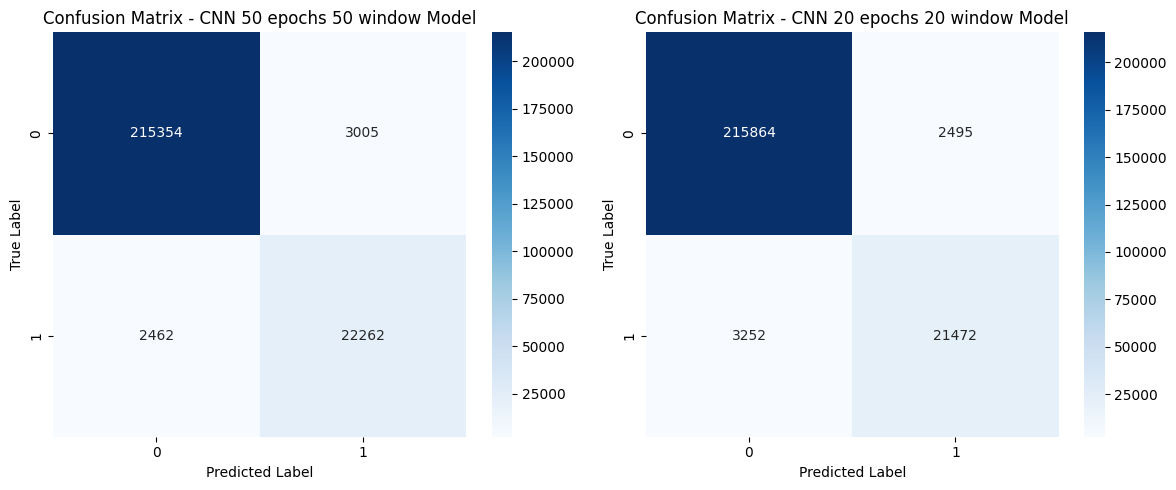

In [42]:

def plot_confusion_matrices(y_true, y_pred1, y_pred2, model1_name="Model 1", model2_name="Model 2"):
    """
    Plots two confusion matrices side by side for comparison.
    
    :param y_true: Ground truth labels.
    :param y_pred1: Predictions from the first model.
    :param y_pred2: Predictions from the second model.
    :param model1_name: Name of the first model.
    :param model2_name: Name of the second model.
    """
    cm1 = confusion_matrix(y_true, y_pred1)
    cm2 = confusion_matrix(y_true, y_pred2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Confusion matrix for Model 1
    sns.heatmap(cm1, annot=True, fmt='d', cmap="Blues", ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - {model1_name}')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Confusion matrix for Model 2
    sns.heatmap(cm2, annot=True, fmt='d', cmap="Blues", ax=axes[1])
    axes[1].set_title(f'Confusion Matrix - {model2_name}')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()


plot_confusion_matrices(y_val, cnn_val_y_pred, cnn20_val_y_pred, "CNN 50 epochs 50 window Model",  "CNN 20 epochs 20 window Model")

#### The results show that the 20-epoch model has fewer false negatives but more false positives compared to other models. This means it is better at correctly detecting actual falls but sometimes mistakenly identifies a fall when there isn’t one.

#### For fall detection, minimizing false negatives is more important than minimizing false positives. A false positive (incorrectly predicting a fall) may cause an unnecessary alert, but it does not pose a serious risk. However, a false negative (failing to detect an actual fall) could be dangerous, as it may prevent timely assistance.

#### Therefore, even though the 20-epoch model is less efficient in terms of overall accuracy and speed (0.06 s vs 00.5 s reaction time), it is better suited for fall detection because it prioritizes detecting falls over avoiding false alarms. This makes it ideal for applications where missing a real fall is a greater concern than occasional false alerts.

## Feature Engineering

##### We have now come to the 
